# Setup
## Import and Git

In [109]:
import bw2io as bi
import bw2data as bd
import bw2calc as bc
import git

import networkx as nx
import random



In [90]:
def get_git_root():
    repo = git.Repo(search_parent_directories=True)
    return repo.git.rev_parse("--show-toplevel")
root = get_git_root()

## Brightway setup

In [91]:
bd.projects.set_current('SEE_LAB') 
eidb = bd.Database("ecoinvent-3.9.1-cutoff")

# Exploration

## Brightway structure

In [92]:
random_act = eidb.random()
random_act.as_dict()

{'comment': "This dataset is an adaptation of “transport, freight, lorry 7.5-16 metric ton, EURO5” in Europe, as available in version 3.6 of the ecoinvent database to reflect the situation in Brazil. It represents the service of 1tkm freight transport in a lorry of the size class 7.5-16 metric tons gross vehicle weight (GVW) and Euro 5 emissions class.\nThe Brazilian lorry fleet is regulated under the Vehicles Air Pollution Control Program – Proconve, which phases are equivalent to the European control program – EURO. Since 2012, the Proconve P7 (EURO 5) phase is in practice, while the P8 phase (EURO 6) will start in 2023. Before that, the Proconve P6 phase (EURO 4) was not implemented because of the unavailability of low-sulphur diesel, therefore recontextualized datasets do not consider this phase. The P5 (EURO 3), P4 (EURO 2) and P3 (EURO 1) phases started in 2005, 2000 and 1996, respectively. Prior technologies are classified as unregulated.\nNone\nFor the dataset recontextualizati

In [93]:
random_exc = [exc for exc in random_act.exchanges()][0].as_dict()
random_exc

{'flow': '24f5a760-85ea-4ed7-a4f2-cff90141671b',
 'type': 'production',
 'name': 'transport, freight, lorry 7.5-16 metric ton, EURO5',
 'classifications': {'CPC': ['6511: Road transport services of freight']},
 'production volume': 26749440000.0,
 'properties': {'carbon allocation': {'amount': 0.0, 'unit': 'kg'},
  'carbon content': {'amount': 0.0, 'unit': 'dimensionless'},
  'price': {'amount': 0.0405042240778858,
   'comment': 'Calculated based on inputs: The price of the product has been calculated as a sum of the values of the material and energy inputs for this product. This value is therefore a rough estimation. It may underestimate the real price since there are additional expenses when producing any product. These expences can include for example labour costs, treatment of waste materials and profit for the producer. Please consider carefully whether this level of data quality is acceptable for your application.',
   'unit': 'EUR2005'}},
 'activity': 'eebe2fbd-3410-5a69-a3e2-59

As we can see, each exchange stores an "input" and "ouput" var (when treated as a dict). 

Our goal is to use this exchange as an edge between the two nodes.

So first we'll get make just a node graph of all the processes (and maybe a bipartite network between biosphere and technosphere?)

And then we'll iterate through all the edges and join them.


**Note**: from the initial import as well as manually iterating (deleted), we know that t process count is 21238, while the exchange count is 674593 (for ecoinvent 3.9.1 -- but maybe we should upgrade to 3.11)



## Make a graph from the database

In [94]:
G = nx.DiGraph()

## attach the nodes
for act in eidb:
    G.add_node(act['code'], **act)

G.number_of_nodes()

21238

In [95]:
G.nodes['e495b85a7516ed20273027cd2e3804fe']

{'comment': 'This is a market activity. Each market represents the consumption mix of a product in a given geography, connecting suppliers with consumers of the same product in the same geographical area. Markets group the producers and also the imports of the product (if relevant) within the same geographical area. They also account for transport to the consumer and for the losses during that process, when relevant.\nThis dataset represents the global market for Cross-laminated timber (CLT). \nCLT production is geographically much focused on Alpine Europe, where the technology was originally developed. For example, Austria, Germany, and Switzerland together had almost 80% of global production capacity in 2015, whereby Austria alone holds 60% of global capacity (Muszynski et al., 2017). Other producing regions include France, the UK, Finland, Latvia, Japan, and the US.\nThe global annual production of CLT was estimated between 600,000 m3 in 2013 and one million m3 in 2015 (Muszynski et

In [96]:
# random_exc = [exc for exc in eidb.random().exchanges()][0].as_dict()
random_exc

{'flow': '24f5a760-85ea-4ed7-a4f2-cff90141671b',
 'type': 'production',
 'name': 'transport, freight, lorry 7.5-16 metric ton, EURO5',
 'classifications': {'CPC': ['6511: Road transport services of freight']},
 'production volume': 26749440000.0,
 'properties': {'carbon allocation': {'amount': 0.0, 'unit': 'kg'},
  'carbon content': {'amount': 0.0, 'unit': 'dimensionless'},
  'price': {'amount': 0.0405042240778858,
   'comment': 'Calculated based on inputs: The price of the product has been calculated as a sum of the values of the material and energy inputs for this product. This value is therefore a rough estimation. It may underestimate the real price since there are additional expenses when producing any product. These expences can include for example labour costs, treatment of waste materials and profit for the producer. Please consider carefully whether this level of data quality is acceptable for your application.',
   'unit': 'EUR2005'}},
 'activity': 'eebe2fbd-3410-5a69-a3e2-59

Note that we have a choice of edge weight here. Possible options include:

* Production Volume
* Any of the properties eg:
    * carbon acollocation 
    * carbon content
    * price 
    * amount

But none of them *really* make sense to me to use. I suspect in the end we'll probably end up using different ones for different analysis for different types of processes. For now we'll use production volume.

In [ ]:
## Build the exchanges
for act in eidb:
    for exc in act.exchanges():
        G.add_edge(exc["input"][1], exc["output"][1], **exc, weight=exc.get('production_volume', 0))



In [98]:
G.nodes['4695730316b4d42e7f6f52a22aebee63']

{'comment': 'This activity represents the reduction of pressure, from high to low, for the distribution of natural gas [m3] to end-users. \nIncluded activities start:  Only the input of natural gas at high pressure (from regional distribution) considered in this activity.\nIncluded activities end:  Pressure reduction from high to low pressure, for supply to local distribution network. Energy requirements, losses and emissions, and infrastructure for the distribution at the different pressure levels are considered in the corresponding market activities. \nGeography:  This geography represents the subset of European countries, excluding the following: Belgium, Switzerland, Germany, Spain, France, United Kingdom, italy, Netherlands\nTechnology:  Within this dataset, natural gas gas at high pressure(1-5 bar overpressure) is converted to low pressure (0.1 bar overpressure) for local distribution, e.g., for residential use.',
 'classifications': [('ISIC rev.4 ecoinvent',
   '3520:Manufacture

The above is the activity for reducing the pressure of a natural gas for high pressure to low pressure for the "Rest of Europe," that is, the average of the nations not explicitly defined.

It's exchanges are what link this process to other processes. From ecoquery we see that they are: 

* Consuming
    * market for natural gas, low pressure, ROE

* Inputs
    * market for natural gas, high pressure AT
    * market for natural gas, high pressure CZ

In [140]:
out_edges = G.out_edges('4695730316b4d42e7f6f52a22aebee63', data=True)
for u, v, edge_data in out_edges:
    print(f"Edge from {u} to {v} with data: {edge_data} \n\t has {G.nodes[u]['location']} as location")


Edge from 4695730316b4d42e7f6f52a22aebee63 to 40bccd8d0b93d2e058476865a14f0a52 with data: {'flow': '609fae33-2e89-4b99-8129-b1f80a6dda33', 'type': 'technosphere', 'name': 'natural gas, low pressure', 'classifications': {'CPC': ['69120: Gas distribution through mains (on own account)']}, 'production volume': 0.0, 'properties': {'carbon allocation': {'amount': 0.544635, 'unit': 'kg'}, 'carbon content': {'amount': 0.741, 'unit': 'dimensionless'}, 'carbon content, fossil': {'amount': 0.741, 'unit': 'dimensionless'}, 'carbon content, non-fossil': {'amount': 0.0, 'unit': 'dimensionless'}, 'dry mass': {'amount': 0.735, 'unit': 'kg'}, 'heating value, gross': {'amount': 40.0, 'unit': 'MJ'}, 'heating value, net': {'amount': 36.0, 'unit': 'MJ'}, 'price': {'amount': 0.205, 'unit': 'EUR2005'}, 'water content': {'amount': 0.0, 'unit': 'dimensionless'}, 'water in wet mass': {'amount': 0.0, 'unit': 'kg'}, 'wet mass': {'amount': 0.735, 'unit': 'kg'}}, 'activity': 'e677421d-6176-5448-9bcc-6be95554985c',

In [147]:
G.nodes['40bccd8d0b93d2e058476865a14f0a52']

{'comment': 'This is a market activity. Each market represents the consumption mix of a product in a given geography, connecting suppliers with consumers of the same product in the same geographical area. Markets group the producers and the imports of the product (if relevant) within the same geographical area. They also account for transport (distribution) to the consumer and for the losses during that process, when relevant.\nThis is the market for ‘natural gas, low pressure" [m3], in the geography of a subset of countries within Europe (RER). \nThe consumption mix is supplied (after pressure reduction) by the corresponding market activity for natural gas at high pressure. \nThe product ‘natural gas, low pressure" is a fossil fuel, for which a generic gross calorific value (GCV) of 40MJ/m3, a net calorific value (NCV) of 36.0 MJ/m3 and a density of 0.735kg/m3 for natural gas are applied, in line with the global statistics (referring to standard cubic meters, Sm3, measured at 15°C and

Interesting, we get one MORE consuming (outgoing) edge than ecoquery suggests. One for the *market* for the low pressure gas and one that just goes back to itself. Not sure why that second one is generated.

Now we look at the incoming edges, which we confirm as being high pressure gas from various locations. Again, for whatever reason the first edge is self-referential. 

In [139]:
incoming_edges = G.in_edges('4695730316b4d42e7f6f52a22aebee63', data=True)
for u, v, edge_data in incoming_edges:
    print(f"Edge from {u} to {v} with data: {edge_data} \n\t has {G.nodes[u]['location']} as location")

    # print(f"\t {u} has location: {input['location']}")
print("\n")

Edge from 4695730316b4d42e7f6f52a22aebee63 to 4695730316b4d42e7f6f52a22aebee63 with data: {'flow': '609fae33-2e89-4b99-8129-b1f80a6dda33', 'type': 'production', 'name': 'natural gas, low pressure', 'classifications': {'CPC': ['69120: Gas distribution through mains (on own account)']}, 'production volume': 72149000000.0, 'properties': {'carbon allocation': {'amount': 0.544635, 'unit': 'kg'}, 'carbon content': {'amount': 0.741, 'unit': 'dimensionless'}, 'carbon content, fossil': {'amount': 0.741, 'comment': 'C content considered the same as in high pressure (consumption mix)', 'unit': 'dimensionless'}, 'carbon content, non-fossil': {'amount': 0.0, 'unit': 'dimensionless'}, 'dry mass': {'amount': 0.735, 'unit': 'kg'}, 'heating value, gross': {'amount': 40.0, 'comment': 'At standard conditions, and assuming amount equal to that of high pressure; based on Meili et al. (2022) section 5.5', 'unit': 'MJ'}, 'heating value, net': {'amount': 36.0, 'comment': 'Literature value, Source: United Nati

Lets zoom in one of those high pressure gas processes. What's in that? (and iterate on that for a while)

In [151]:
G.nodes['84c52a94bf58be855ac22e6a538a16ba']

{'comment': 'This is a market activity. Each market represents the consumption mix of a product in a given geography, connecting suppliers with consumers of the same product in the same geographical area. Markets group the producers and the imports of the product (if relevant) within the same geographical area. They also account for transport (distribution) to the consumer and for the losses during that process, when relevant.\nThis is the market for ‘natural gas, high pressure" [m3], in the geography of Poland. The country-specific supply situation in 2019 was modelled based on production and trade statisitcs from EuroStat (2022a,b). The share of domestic production was approximated by supply from Germany. This activitiy contains information on energy and transport requirements (excluding for any imports, which are modelled in separate datasets) and the losses and emissions occurring during the distribution from Faist-Emmenegger et al. (2017).\nThe product ‘natural gas, high pressure"

In [156]:
incoming_edges = G.in_edges('84c52a94bf58be855ac22e6a538a16ba', data=True)
for u, v, edge_data in incoming_edges:
    input = G.nodes[u]
    if input:
        print(input['name'], 'location=', input['location'], ':', u, v, edge_data)

    # print(f"\t {u} has location: {input['location']}")
print("\n")

market for natural gas, high pressure location= PL : 84c52a94bf58be855ac22e6a538a16ba 84c52a94bf58be855ac22e6a538a16ba {'flow': 'a9007f10-7e39-4d50-8f4a-d6d03ce3d673', 'type': 'technosphere', 'name': 'natural gas, high pressure', 'classifications': {'CPC': ['12020: Natural gas, liquefied or in the gaseous state']}, 'production volume': 0.0, 'properties': {'carbon allocation': {'amount': 0.544635, 'unit': 'kg'}, 'carbon content': {'amount': 0.741, 'unit': 'dimensionless'}, 'carbon content, fossil': {'amount': 0.741, 'unit': 'dimensionless'}, 'carbon content, non-fossil': {'amount': 0.0, 'unit': 'dimensionless'}, 'dry mass': {'amount': 0.735, 'unit': 'kg'}, 'heating value, gross': {'amount': 40.0, 'unit': 'MJ'}, 'heating value, net': {'amount': 36.0, 'unit': 'MJ'}, 'price': {'amount': 0.166, 'unit': 'EUR2005'}, 'water content': {'amount': 0.0, 'unit': 'dimensionless'}, 'water in wet mass': {'amount': 0.0, 'unit': 'kg'}, 'wet mass': {'amount': 0.735, 'unit': 'kg'}}, 'activity': '15a8900d-

In [163]:
incoming_edges = G.in_edges('57c178984cb1d22b4525fbd56906b0c6', data=True)
for u, v, edge_data in incoming_edges:
    input = G.nodes[u]
    if input:
        print(input['name'], 'location=', input['location'], ':', u, v, edge_data)

    # print(f"\t {u} has location: {input['location']}")
print("\n")

market for electricity, medium voltage location= PL : 57c178984cb1d22b4525fbd56906b0c6 57c178984cb1d22b4525fbd56906b0c6 {'flow': '759b89bd-3aa6-42ad-b767-5bb9ef5d331d', 'type': 'technosphere', 'name': 'electricity, medium voltage', 'classifications': {'CPC': ['17100: Electrical energy']}, 'production volume': 0.0, 'properties': {'carbon allocation': {'amount': 0.0, 'unit': 'kg'}, 'carbon content': {'amount': 0.0, 'unit': 'dimensionless'}, 'price': {'amount': 0.1, 'unit': 'EUR2005'}}, 'activity': '1dadaa32-0800-5801-93a2-ef5845fea64c', 'unit': 'kilowatt hour', 'amount': 0.00273139403743587, 'uncertainty type': 0, 'loc': 0.00273139403743587, 'input': ('ecoinvent-3.9.1-cutoff', '57c178984cb1d22b4525fbd56906b0c6'), 'output': ('ecoinvent-3.9.1-cutoff', '57c178984cb1d22b4525fbd56906b0c6'), 'weight': 0}
electricity voltage transformation from high to medium voltage location= PL : eee1d6168852e91e9403db3dc9081472 57c178984cb1d22b4525fbd56906b0c6 {'flow': '759b89bd-3aa6-42ad-b767-5bb9ef5d331d',

In [164]:
incoming_edges = G.in_edges('1a661f7ce0fdd2bdadd3992daa8126c1', data=True)
for u, v, edge_data in incoming_edges:
    input = G.nodes[u]
    if input:
        print(input['name'], 'location=', input['location'], ':', u, v, edge_data)

    # print(f"\t {u} has location: {input['location']}")
print("\n")

market for sulfur hexafluoride, liquid location= RER : 1a661f7ce0fdd2bdadd3992daa8126c1 1a661f7ce0fdd2bdadd3992daa8126c1 {'flow': 'ab5dcfa8-e8f9-4923-84d4-51b25a898fa1', 'type': 'production', 'name': 'sulfur hexafluoride, liquid', 'classifications': {'CPC': ['342: Basic inorganic chemicals n.e.c.']}, 'production volume': 1.32236940655721, 'properties': {'carbon allocation': {'amount': 0.0, 'unit': 'kg'}, 'carbon content': {'amount': 0.0, 'unit': 'dimensionless'}, 'carbon content, fossil': {'amount': 0.0, 'unit': 'dimensionless'}, 'carbon content, non-fossil': {'amount': 0.0, 'unit': 'dimensionless'}, 'dry mass': {'amount': 1.0, 'unit': 'kg'}, 'price': {'amount': 3.387337286, 'comment': 'Calculated based on inputs: The price of the product has been calculated as a sum of the values of the material and energy inputs for this product. This value is therefore a rough estimation. It may underestimate the real price since there are additional expenses when producing any product. These expenc

In [165]:
incoming_edges = G.in_edges('62f96280fc2bd351e2ce98e3813e7278', data=True)
for u, v, edge_data in incoming_edges:
    input = G.nodes[u]
    if input:
        print(input['name'], 'location=', input['location'], ':', u, v, edge_data)

    # print(f"\t {u} has location: {input['location']}")
print("\n")

sulfur hexafluoride production, liquid location= RER : 62f96280fc2bd351e2ce98e3813e7278 62f96280fc2bd351e2ce98e3813e7278 {'flow': 'ab5dcfa8-e8f9-4923-84d4-51b25a898fa1', 'type': 'production', 'name': 'sulfur hexafluoride, liquid', 'classifications': {'CPC': ['342: Basic inorganic chemicals n.e.c.']}, 'production volume': 1.32236940655721, 'properties': {'carbon allocation': {'amount': 0.0, 'unit': 'kg'}, 'carbon content': {'amount': 0.0, 'unit': 'dimensionless'}, 'carbon content, fossil': {'amount': 0.0, 'comment': 'SF6', 'unit': 'dimensionless'}, 'carbon content, non-fossil': {'amount': 0.0, 'comment': 'SF6', 'unit': 'dimensionless'}, 'dry mass': {'amount': 1.0, 'unit': 'kg'}, 'price': {'amount': 3.387337286, 'comment': 'Calculated based on inputs: The price of the product has been calculated as a sum of the values of the material and energy inputs for this product. This value is therefore a rough estimation. It may underestimate the real price since there are additional expenses when

Okay, this gives us a better sense of how the edges and nodes are operating, and makes me feel bettter about using production volume as the edge weight.

It seems like maybe we should split the nodes into different types:

* markets
* production

For now, lets get a little drawing of a subgraph of our initial node.

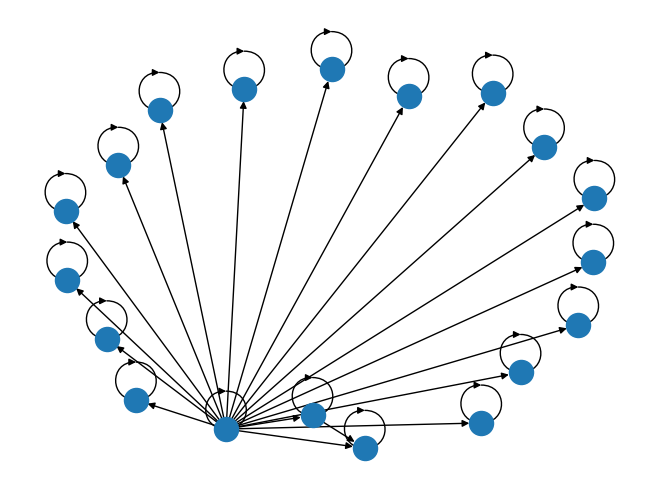

In [175]:
subgraph = G.subgraph( ['84c52a94bf58be855ac22e6a538a16ba'] + list(G.neighbors('84c52a94bf58be855ac22e6a538a16ba')))
edge_weights = [subgraph[u][v]['weight'] for u, v in subgraph.edges()]

nx.draw(subgraph)

We can also pick two nodes and see what kind of edge connects them

In [107]:
G.get_edge_data('4695730316b4d42e7f6f52a22aebee63', '4695730316b4d42e7f6f52a22aebee63')

{'flow': '609fae33-2e89-4b99-8129-b1f80a6dda33',
 'type': 'production',
 'name': 'natural gas, low pressure',
 'classifications': {'CPC': ['69120: Gas distribution through mains (on own account)']},
 'production volume': 72149000000.0,
 'properties': {'carbon allocation': {'amount': 0.544635, 'unit': 'kg'},
  'carbon content': {'amount': 0.741, 'unit': 'dimensionless'},
  'carbon content, fossil': {'amount': 0.741,
   'comment': 'C content considered the same as in high pressure (consumption mix)',
   'unit': 'dimensionless'},
  'carbon content, non-fossil': {'amount': 0.0, 'unit': 'dimensionless'},
  'dry mass': {'amount': 0.735, 'unit': 'kg'},
  'heating value, gross': {'amount': 40.0,
   'comment': 'At standard conditions, and assuming amount equal to that of high pressure; based on Meili et al. (2022) section 5.5',
   'unit': 'MJ'},
  'heating value, net': {'amount': 36.0,
   'comment': 'Literature value, Source: United Nations Statistics Division (2018) International Recommendatio